# Signal to interference ratio

The purpose of this script is to demonstrate that SIR is a better metric than correlation coefficient when evaluating the performance of blind source separation algorithms.

In [2]:
from itertools import product
import numpy as np
from numpy import pi, sin, cos, tan
from scipy.io import wavfile
from scipy.signal import spectrogram

from matplotlib import pyplot as plt
from matplotlib import cm
import museval

Assuming that "../scripts/input_mix_bc.py" has already been executed.

In [3]:
src = np.load("../input/bc/src.npy")

In [8]:
print(f"Correlation between the two signals: {np.corrcoef(src.T)[0,1]}")

Correlation between the two signals: -0.012080022423447564


Create mixtures of signals.

In [9]:
qs = np.linspace(0, 0.25, 11)
M = np.zeros((11, *src.shape))
for i,q in enumerate(qs):
    Q = np.array([[cos(q*pi), sin(q*pi)],
                  [sin(q*pi), cos(q*pi)]])
    M[i] = src.dot(Q)
    M[i] = M[i]/abs(M[i]).max(0)

Create noisy mixtures of signals, 

In [21]:
nsample = 10
X = np.zeros((6, 11, nsample, 500000))
for i in range(6):
    X[i] = M[:,:,0].reshape(11, 1, 500000) + i*0.1*np.random.randn(11, nsample, 500000)

Compute the correlations with the first source signal.

In [22]:
r = np.zeros((6, 11, nsample))
for i in range(6):
    for j in range(11):
        r[i,j] = np.corrcoef(src[:,0], X[i,j])[0,1:]

In [23]:
ravg = r.mean(2)
rstd = r.std(2)
rhi = ravg + rstd
rlow = ravg - rstd

The mean of the signal after rescaling would affect SIR. (Consider the profile in the frequency space.)

In [24]:
sir = np.empty((6, 11, nsample))
for i in range(6):
    for j in range(11):
        for k in range(nsample):
            _, _, tmp, _, _ = museval.metrics.bss_eval(src.T, X[i,j,[k,k]], compute_permutation=False, window=np.inf)
            sir[i,j] = tmp[0,0]

In [25]:
sir_avg = sir.mean(2)
sir_std = sir.std(2)
sir_hi = sir_avg + sir_std
sir_low = sir_avg - sir_std

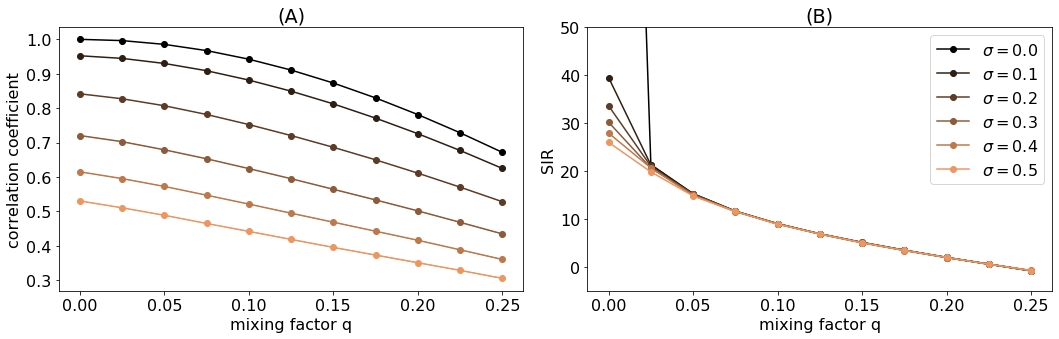

In [29]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,2, figsize=(15,5))
ax = axes[0]
cmap = cm.copper
for i in range(6):
    ax.plot(qs, ravg[i], 'o-', color=cmap(0.15*i), label=f'$\sigma=${0.1*i:.1f}')
    ax.fill_between(qs, rlow[i], rhi[i], facecolor='grey')
ax.set_xlabel(f'mixing factor q')
ax.set_ylabel('correlation coefficient')
ax.set_title('(A)')

ax = axes[1]
for i in range(6):
    ax.plot(qs, sir_avg[i], 'o-', color=cmap(0.15*i), label=f'$\sigma=${0.1*i:.1f}')
    ax.fill_between(qs, sir_low[i], sir_hi[i], facecolor='grey')
ax.set_ylim([-5,50])
ax.set_xlabel(f'mixing factor q')
ax.set_ylabel('SIR')
ax.set_title('(B)')
ax.legend()
plt.tight_layout()
#plt.savefig('../asset/metric.png', dpi=300)
plt.show()

Same level of correlation coefficient may indicate different levels of mixing. "Pure" but noisy signals may be scored as low as "mixed" but clean signals. <br>
On the other hand, SIR is relatively insensitive to noise except for pure signals.